# Recurrent expander learning 8/20

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import grad, jit, vmap
from numpy import random
import numpy as onp

from tqdm import tqdm_notebook as tqdm

In [2]:
import seaborn as sns
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Beer Barak '19

In [181]:
@jit
def RNN_step(a,h,u,z,w_out,dtdivtau):
    dadt = -a + w_in*u + J@h + w_fb@z
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = w_out@h
    
    return a,h,z

In [34]:
@jit 
def RLS(P,h,z,f,w_out):
    # RLS    
    Ph = P@h
    hPh = h.T@Ph
    c = 1.0/(1.0 + hPh)
    P = P - c*np.outer(Ph,Ph)

    e = z-f
    dw = -e[:,None]*(P@h)
    w_out = w_out + dw
    return P, w_out

In [182]:
@jit 
def RLS(P,h,z,f,w_out):
    # update inverse correlation matrix
    k = np.expand_dims(np.dot(P, h), axis=1)
    hPh = np.dot(h.T, k)
    c = 1.0/(1.0 + hPh)
    P = P - np.dot(k*c, k.T)

    # update the output weights
    e = np.atleast_2d(z-f)
    dw = np.dot(-c*k, e).T
    w_out = w_out + dw
    
    return P, w_out 

## Memory task

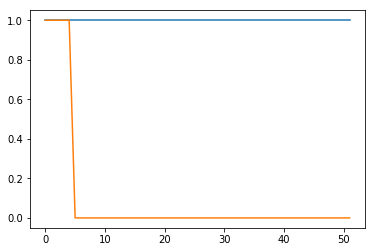

In [7]:
dt = 1e-1
def construct_input(amp,delay):
    t_pres = int(0.5/dt)
    t_delay = np.int16(delay/dt)
    
    u_pres = amp*np.ones(t_pres)
    u_delay = np.zeros(t_delay)
    u = np.concatenate([u_pres,u_delay])
    
    f = amp*np.ones(t_pres+t_delay)

    return u,f

construct_input = jit(construct_input,static_argnums=1)

delay = random.uniform(0.5,6)
u,f = construct_input(1, delay)
plt.plot(f)
plt.plot(u);

In [ ]:
tau = 1e-1
n_trials = 500
alpha = 10
output_dim = 1
dtdivtau = dt/tau

N = 500
g = 1.2

# Initialize P
P = np.eye(N) / alpha

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
w_out = np.zeros((output_dim,N))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

amps = random.uniform(1,5,9)
delays = np.device_put(random.uniform(0.5,6,n_trials+10))

errs = []
for trial in tqdm(range(n_trials)):
    # Train
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[trial])
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        # RLS
        P,w_out = RLS(P,h,z,f,w_out)
        
    # Validate
    if trial % 5 == 4:
        zs = []
        fs_all = []
        for i in range(10):
            amp = random.choice(amps)
            us,fs = construct_input(amp,delays[i])
            fs_all.append(fs)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
                zs.append(z)
        zs = np.concatenate(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)

# Final validation
zs = []
fs_all = []
us_all = []
for i in range(10):
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[i])
    fs_all.append(fs)
    us_all.append(us)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.concatenate(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

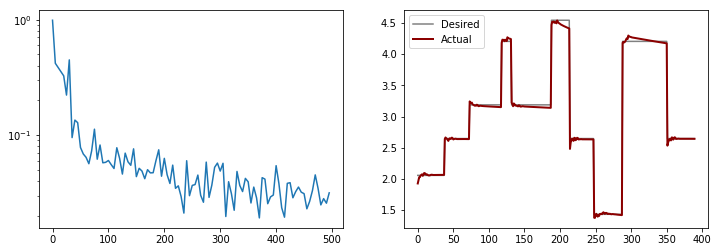

In [148]:
plt.figure(figsize=(12,4))
plt.subplot(121)
T = np.arange(len(errs))*5
plt.plot(T,errs)
plt.yscale('log')

plt.subplot(122)
plt.plot(fs_all, c='grey', label='Desired')
plt.plot(zs, c='darkred', linewidth=2, label='Actual');
plt.legend();

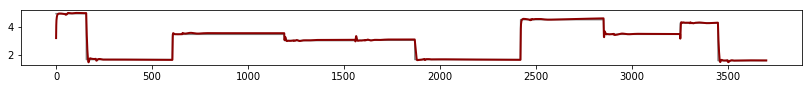

In [225]:
plt.figure(figsize=(14,1))
# plt.plot(us_all);
plt.plot(fs_all, c='grey')
plt.plot(zs, c='darkred', linewidth=2);

## Frequency generator task

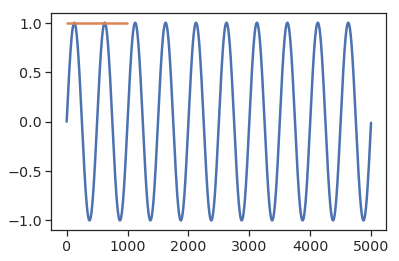

In [37]:
dt = 2e-3
def build_frequency(f):
    period = int(1/(dt*f))

    # Inputs
    u0 = f*np.ones(2*period)
    u1 = np.zeros(10*period)
    u = np.concatenate([u0,u1])

    # Target outputs
    z0 = np.zeros((2,2*period))
    T = np.arange(10*period)
    zsin = np.sin(2*np.pi*T*f*dt)
    zcos = np.cos(2*np.pi*T*f*dt)
    z1 = np.vstack([zsin,zcos])
    f = np.hstack([z0,z1]).T
    return u0,u1,z1.T


u0,u1,f = build_frequency(1)
plt.plot(f[:,0])
plt.plot(u0);

In [ ]:
tau = 1e-1
n_trials = 500
alpha = 10
output_dim = 2
dtdivtau = dt/tau
val_freq = 5          # validate after this many trials

N = 1000
g = 1.2

# Initialize P
P = np.eye(N) / alpha

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
# w_in = random.uniform(-1,1,N)
w_in = random.randn(N)
w_fb = random.uniform(-1,1,(N,output_dim))
w_out = np.zeros((output_dim,N))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

freqs = random.uniform(0.2,1.1,10)

errs = []
for trial in tqdm(range(n_trials)):
    
    # Train
    freq = random.choice(freqs)
    us0,us,fs = build_frequency(freq)
    
    for u in us0:
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
    
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        # RLS
        P,w_out = RLS(P,h,z,f,w_out)
        
    # Validate
    if trial % val_freq == val_freq-1:
        zs = []
        fs_all = []
        for i in range(5):
            freq = random.choice(freqs)
            us0,us,fs = build_frequency(freq)
            fs_all.append(fs)
            for u in us0:
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
                zs.append(z)
        zs = np.vstack(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)
        print('Err: ' + str(err))

# Final validation
zs = []
fs_all = []
us_all = []
for i in range(2):
    freq = random.choice(freqs)
    us0,us,fs = build_frequency(freq)
    fs_all.append(fs)
    us_all.append(us)
    for u in us0:
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.vstack(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

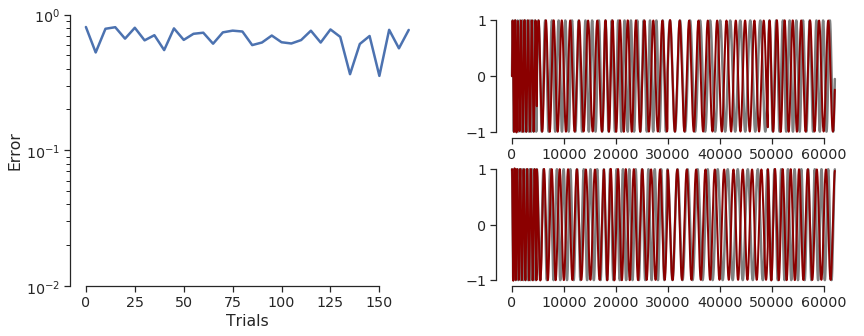

In [41]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[:,0])
T = np.arange(len(errs))*val_freq
plt.plot(T,errs)
plt.yscale('log')
plt.ylim([1e-2,1])
plt.ylabel('Error')
plt.xlabel('Trials')

ax2 = fig.add_subplot(gs[0,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,0], c='grey', label='Desired')
    plt.plot(zs[:,0], c='darkred', linewidth=2, label='Actual');
    
#     plt.legend();
ax3 = fig.add_subplot(gs[1,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,1], c='grey', label='Desired')
    plt.plot(zs[:,1], c='darkred', linewidth=2, label='Actual');
    sns.despine(trim=True)

# Recurrent expander

In [66]:
def heaviside(x):
    return (np.sign(x) + 1) / 2

In [67]:
@jit
def RNN_step(a,h,u,z,w_out,wh,dtdivtau):
    dadt = -a + w_in*u + J@h + w_fb@z
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    
    b = heaviside(wh@h)
    z = w_out@b
    
    return a,h,b,z

In [68]:
@jit 
def RLS(P,h,z,f,w_out):
    # update inverse correlation matrix
    k = np.expand_dims(np.dot(P, h), axis=1)
    hPh = np.dot(h.T, k)
    c = 1.0/(1.0 + hPh)
    P = P - np.dot(k*c, k.T)

    # update the output weights
    e = np.atleast_2d(z-f)
    dw = np.dot(-c*k, e).T
    w_out = w_out + dw
    
    return P, w_out 

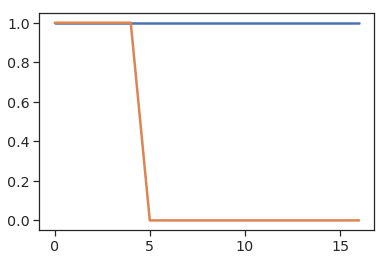

In [69]:
dt = 1e-1
def construct_input(amp,delay):
    t_pres = int(0.5/dt)
    t_delay = np.int16(delay/dt)
    
    u_pres = amp*np.ones(t_pres)
    u_delay = np.zeros(t_delay)
    u = np.concatenate([u_pres,u_delay])
    
    f = amp*np.ones(t_pres+t_delay)

    return u,f

construct_input = jit(construct_input,static_argnums=1)

delay = random.uniform(0.5,6)
u,f = construct_input(1, delay)
plt.plot(f)
plt.plot(u);

In [70]:
tau = 1e-1
n_trials = 500
alpha = 10
output_dim = 1
dtdivtau = dt/tau
val_interval = 5

N = 300
M = 500
g = 1.2

# Initialize P
P = np.eye(M) / alpha

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
wh = random.randn(M,N) / np.sqrt(N)
w_out = np.zeros((output_dim,M))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

amps = random.uniform(1,5,9)
delays = np.device_put(random.uniform(0.5,6,n_trials+10))

errs = []
for trial in tqdm(range(n_trials)):
    # Train
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[trial])
    for u,f in zip(us,fs):
        # Run RNN
        a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
        # RLS
        P,w_out = RLS(P,b,z,f,w_out)
        
    # Validate
    if trial % val_interval == val_interval - 1:
        zs = []
        fs_all = []
        for i in range(10):
            amp = random.choice(amps)
            us,fs = construct_input(amp,delays[i])
            fs_all.append(fs)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
                zs.append(z)
        zs = np.concatenate(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)

# Final validation
zs = []
fs_all = []
us_all = []
for i in range(10):
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[i])
    fs_all.append(fs)
    us_all.append(us)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
        zs.append(z)
zs = np.concatenate(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

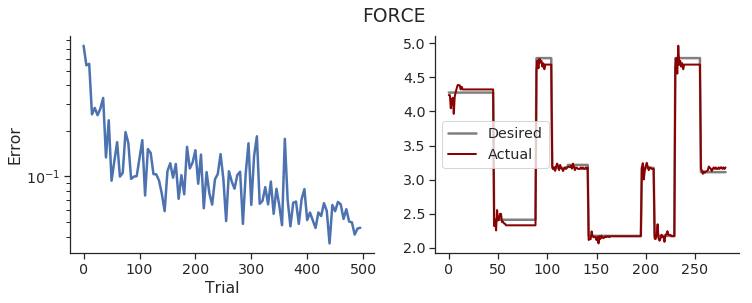

In [71]:
plt.figure(figsize=(12,4))
plt.suptitle('FORCE')
plt.subplot(121)
T = np.arange(len(errs))*5
plt.plot(T,errs)
plt.yscale('log')
plt.xlabel('Trial')
plt.ylabel('Error')
sns.despine()

plt.subplot(122)
plt.plot(fs_all, c='grey', label='Desired')
plt.plot(zs, c='darkred', linewidth=2, label='Actual');
plt.legend();
sns.despine()

## LMS

In [72]:
@jit 
def LMS(h,z,f,w_out,eta):
    e = f-z
    dw = np.outer(e,h)
    w_out = w_out + eta*dw
    
    return w_out 

In [73]:
@jit
def RNN_step(a,h,u,z,w_out,wh,dtdivtau):
    dadt = -a + w_in*u + J@h + w_fb@z
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    
    b = heaviside(wh@h)
    z = w_out@b
    
    return a,h,b,z

In [74]:
from IPython.display import clear_output

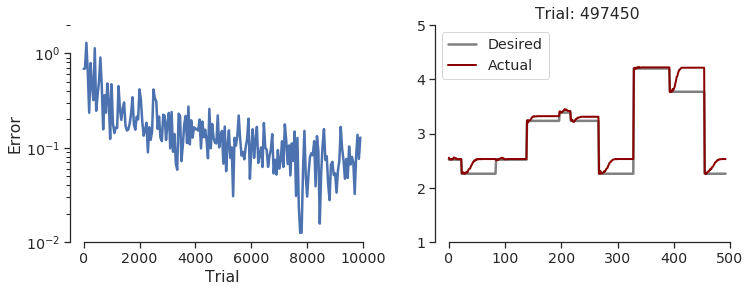

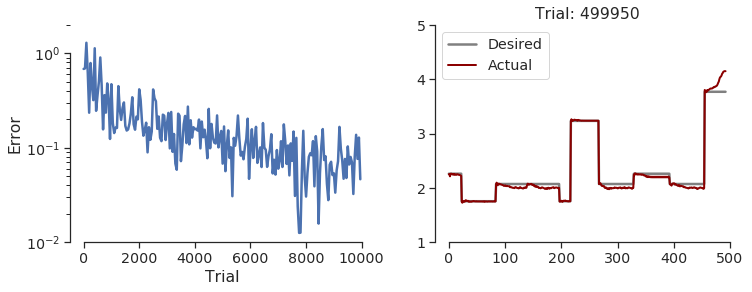

In [77]:
tau = 1e-1
eta = 1e-4
n_targets = 9
n_trials = 10000
alpha = 10
output_dim = 1
dtdivtau = dt/tau
val_interval = 50         # n trials between validation

N = 500
M = 10000
g = 1.2

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
wh = random.randn(M,N) / np.sqrt(N)
w_out = np.zeros((output_dim,M))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

amps = random.uniform(1,5,n_targets)
delays = random.uniform(0.5,6,n_trials+10)

errs = []
for trial in tqdm(range(n_trials)):
    # Train
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[trial])
    for u,f in zip(us,fs):
        # Run RNN
        a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
        # RLS
        w_out = LMS(b,z,f,w_out,eta)
        
    # Validate
    if trial % val_interval == val_interval-1:
        clear_output()
        plt.pause(0.01)
        zs = []
        fs_all = []
        for i in range(10):
            amp = random.choice(amps)
            us,fs = construct_input(amp,delays[i])
            fs_all.append(fs)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
                zs.append(z)
        zs = np.concatenate(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)
        
        plt.figure(figsize=(12,4))
        plt.title(trial)
        plt.subplot(121)
        T = np.arange(len(errs))*val_interval
        plt.plot(T,errs)
        plt.xlabel('Trial')
        plt.ylabel('Error')
        plt.yscale('log')
        plt.ylim([1e-2,2])
        sns.despine(trim=True)
        
        plt.subplot(122)
        plt.plot(fs_all, c='grey', label='Desired')
        plt.plot(zs, c='darkred', linewidth=2, label='Actual');
        plt.legend();
        plt.title('Trial: ' + str(trial*val_interval))
        plt.ylim([1,5])
        sns.despine(trim=True);

In [90]:
zs_all = []
hs_all = []
fs_all = []
bs_all = []
for i in range(10):
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[i])
    fs_all.append(fs)
    zs = []
    hs = []
    bs = []
    for u,f in zip(us,fs):
        # Run RNN
        a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
        bs.append(b)
        zs.append(z)
        hs.append(h)
    zs = np.stack(zs)
    hs = np.stack(hs)
    bs = np.stack(bs)
    zs_all.append(zs)
    hs_all.append(hs)
    bs_all.append(bs)

In [105]:
w = random.randn(10000,2)

In [106]:
b_embed = []
for b in bs_all:
    b_embed.append(b@w)

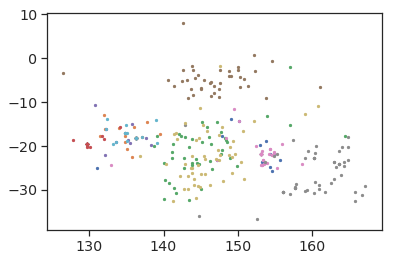

In [107]:
for b in b_embed:
    plt.scatter(b[10:,0],b[10:,1],s=5)

In [115]:
np.vstack(hs_all).shape

(493, 500)

In [116]:
U,S,V = np.linalg.svd(np.vstack(hs_all), full_matrices=False)

In [118]:
V.shape

(493, 500)

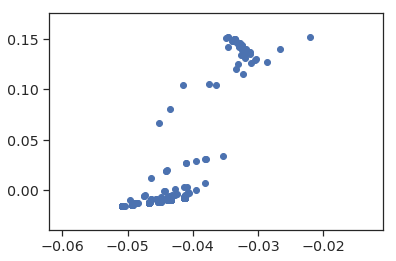

In [117]:
plt.scatter(U[:,0],U[:,1])

In [104]:
bs_all[0].shape

(23, 10000)

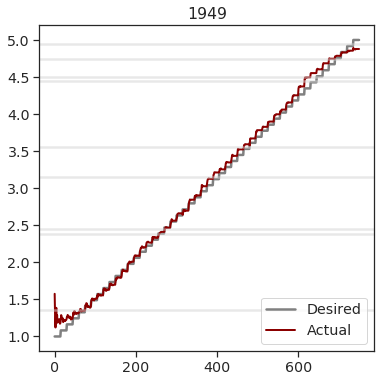

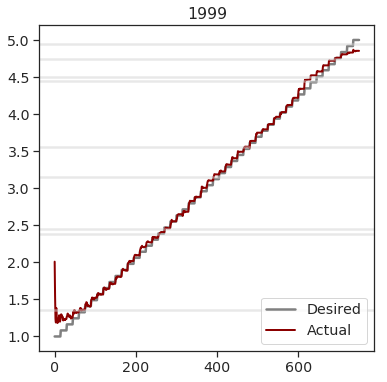

In [37]:
# Estimate q
tau = 1e-1
eta = 2e-4
n_trials = 2000
alpha = 10
output_dim = 1
dtdivtau = dt/tau
val_interval = 50

N = 500
M = 10000
g = 1.2

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
wh = random.randn(M,N) / np.sqrt(M)
w_out = np.zeros((output_dim,M))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

amps = random.uniform(1,5,9)
delays = np.device_put(random.uniform(0.5,6,n_trials+10))

errs = []
qs = []
amp_tests = []
for trial in tqdm(range(n_trials)):
    # Train
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[trial])
    for u,f in zip(us,fs):
        # Run RNN
        a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
        # RLS
        w_out = LMS(b,z,f,w_out,eta)

    # Compute Q
    if trial % val_interval==val_interval-1:
        clear_output()
        plt.pause(0.01)
        amp_tests.append(amp)
        fs_all = []
        zs_all = []
        amp_test = np.linspace(1,5,50)
        for amp in tqdm(amp_test,leave=False):
            zs = []
            delay = 1
            us,fs = construct_input(amp,delay)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,b,z = RNN_step(a,h,0,f[None],w_out,wh,dtdivtau)
                zs.append(z)
            zs = np.concatenate(zs)
            zs_all.append(zs)
            fs_all.append(fs)
            qs.append(np.mean((zs-fs)**2))
        zs_all = np.concatenate(zs_all)
        fs_all = np.concatenate(fs_all)
        plt.figure(figsize=(6,6))
        plt.plot(fs_all, c='grey', label='Desired')
        plt.plot(zs_all, c='darkred', linewidth=2, label='Actual');
        plt.legend();
        plt.title(trial)
        for amp in amps:
            plt.axhline(amp, color='lightgrey', alpha=0.5)

# Final validation
zs = []
fs_all = []
us_all = []
for amp, delay in zip(amps, delays):
    us,fs = construct_input(amp,delay)
    fs_all.append(fs)
    us_all.append(us)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
        zs.append(z)
zs = np.concatenate(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

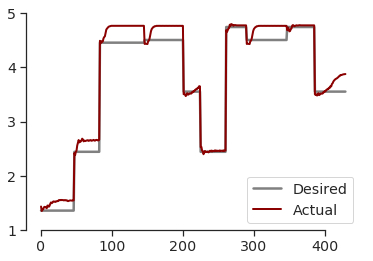

In [39]:
zs = []
fs_all = []
for i in range(10):
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[i])
    fs_all.append(fs)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau)
        zs.append(z)
zs = np.concatenate(zs)
fs_all = np.concatenate(fs_all)
err = np.mean(np.abs(zs-fs_all))
errs.append(err)

plt.figure(figsize=(6,4))
plt.plot(fs_all, c='grey', label='Desired')
plt.plot(zs, c='darkred', linewidth=2, label='Actual');
plt.legend();
plt.ylim([1,5])
sns.despine(trim=True);

In [40]:
qs = np.stack(qs).reshape(n_trials//50, len(amp_test))

In [ ]:
val

Text(0, 0.5, 'Value')

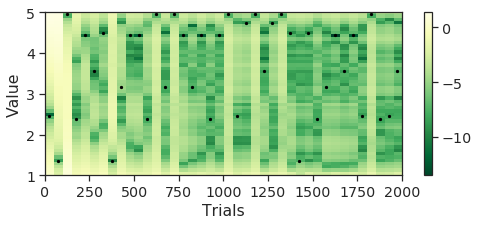

In [62]:
plt.figure(figsize=(8,3))
plt.imshow(np.log(qs.T), extent=(0,n_trials,1,5),
           aspect='auto',origin='lower', cmap='YlGn_r')
plt.colorbar();
plt.scatter(val_interval*(np.arange(len(amp_tests))+0.5),amp_tests,c='black',s=5)
plt.ylim([1,5])
plt.xlabel('Trials')
plt.ylabel('Value')

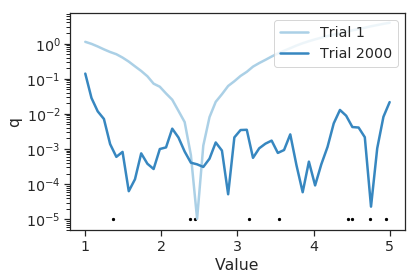

In [50]:
with sns.color_palette('Blues', 2):
    plt.plot(amp_test, qs[0].T, label='Trial 1')
    plt.plot(amp_test, qs[-1].T, label='Trial ' + str(n_trials))
    plt.yscale('log');
    
for amp in amps:
    plt.scatter(amp, 1e-5, c='black', s=5)
plt.legend(loc=1);
plt.ylabel('q')
plt.xlabel('Value');

# Vanilla RNN

In [119]:
def heaviside(x):
    return (np.sign(x) + 1) / 2

@jit
def RNN_step(a,h,u,z,w_out,dtdivtau):
    dadt = -a + w_in*u + J@h + w_fb@z
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = w_out@h
    
    return a,h,z

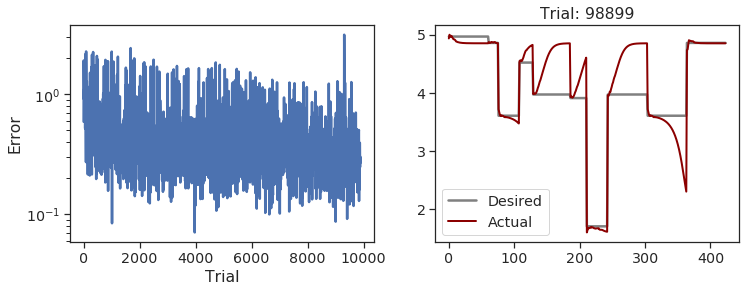

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [121]:
tau = 1e-1
eta = 1e-3
n_targets = 9
n_trials = 100000
alpha = 10
output_dim = 1
dtdivtau = dt/tau

N = 1000
g = 1.2

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
w_out = np.zeros((output_dim,N))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

amps = random.uniform(1,5,n_targets)
delays = random.uniform(0.5,6,n_trials+10)

errs = []
for trial in tqdm(range(n_trials)):
    # Train
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[trial])
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        # RLS
        w_out = LMS(h,z,f,w_out,eta)
        
    # Validate
    if trial % 50 == 49:
        clear_output()
        plt.pause(0.01)
        zs = []
        fs_all = []
        for i in range(10):
            amp = random.choice(amps)
            us,fs = construct_input(amp,delays[i])
            fs_all.append(fs)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
                zs.append(z)
        zs = np.concatenate(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)
        
        plt.figure(figsize=(12,4))
        plt.title(trial)
        plt.subplot(121)
        T = np.arange(len(errs))*5
        plt.plot(T,errs)
        plt.xlabel('Trial')
        plt.ylabel('Error')
        plt.yscale('log')
        plt.subplot(122)
        plt.plot(fs_all, c='grey', label='Desired')
        plt.plot(zs, c='darkred', linewidth=2, label='Actual');
        plt.legend();
        plt.title('Trial: ' + str(trial))

In [130]:
amps

array([3.96939484, 3.60450657, 4.51820111, 4.96564564, 1.70283366,
       4.43031324, 3.9077335 , 1.16602454, 4.85653611])

In [134]:
delays

array([5.64220441, 1.03185102, 2.70659866, ..., 0.59349613, 4.16398162,
       3.97938812])

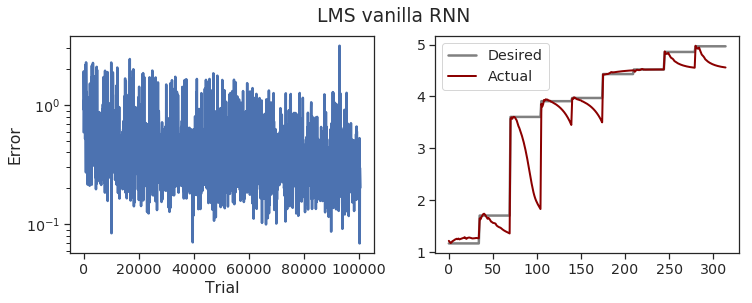

In [138]:
zs = []
fs_all = []
# for i in range(10):
for amp in np.sort(amps):
    delay = random.uniform(0.5,6)
    us,fs = construct_input(amp,3)
    fs_all.append(fs)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.concatenate(zs)
fs_all = np.concatenate(fs_all)
err = np.mean(np.abs(zs-fs_all))
errs.append(err)

plt.figure(figsize=(12,4))
plt.suptitle('LMS vanilla RNN')
plt.subplot(121)
T = np.arange(len(errs))*50
plt.plot(T,errs)
plt.xlabel('Trial')
plt.ylabel('Error')
plt.yscale('log')
plt.subplot(122)
plt.plot(fs_all, c='grey', label='Desired')
plt.plot(zs, c='darkred', linewidth=2, label='Actual');
plt.legend();

In [ ]:
# Estimate q
tau = 1e-1
eta = 1e-3
n_targets = 9
n_trials = 2000
alpha = 10
output_dim = 1
dtdivtau = dt/tau
val_interval = 50

N = 1000
g = 1.2

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
w_out = np.zeros((output_dim,N))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

amps = random.uniform(1,5,n_targets)
delays = random.uniform(0.5,6,n_trials+10)

errs = []
qs = []
amp_tests = []
for trial in tqdm(range(n_trials)):
    # Train
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[trial])
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        # RLS
        w_out = LMS(h,z,f,w_out,eta)

    # Compute Q
    if trial % val_interval==val_interval-1:
        clear_output()
        plt.pause(0.01)
        amp_tests.append(amp)
        fs_all = []
        zs_all = []
        amp_test = np.linspace(1,5,50)
        for amp in tqdm(amp_test,leave=False):
            zs = []
            delay = 1
            us,fs = construct_input(amp,delay)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,z = RNN_step(a,h,0,f[None],w_out,dtdivtau)
                zs.append(z)
            zs = np.concatenate(zs)
            zs_all.append(zs)
            fs_all.append(fs)
            qs.append(np.mean((zs-fs)**2))
        zs_all = np.concatenate(zs_all)
        fs_all = np.concatenate(fs_all)
        plt.figure(figsize=(6,6))
        plt.plot(fs_all, c='grey', label='Desired')
        plt.plot(zs_all, c='darkred', linewidth=2, label='Actual');
        plt.legend();
        plt.title(trial)
        for amp in amps:
            plt.axhline(amp, color='lightgrey', alpha=0.5)

In [ ]:
qs = np.stack(qs).reshape(n_trials//val_interval, len(amp_test))

In [ ]:
plt.figure(figsize=(8,3))
plt.imshow(np.log(qs.T), extent=(0,n_trials//50,1,5),
           aspect='auto',origin='lower', cmap='YlGn_r')
plt.colorbar();
plt.scatter(np.arange(len(amp_tests))+0.5,amp_tests,c='black',s=5)
plt.ylim([1,5])

# Effect of sparseness
Does a sparse expansion layer reduce correlations?

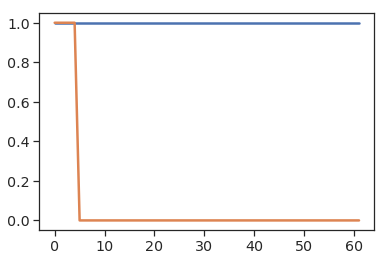

In [139]:
dt = 1e-1
def construct_input(amp,delay):
    t_pres = int(0.5/dt)
    t_delay = np.int16(delay/dt)
    
    u_pres = amp*np.ones(t_pres)
    u_delay = np.zeros(t_delay)
    u = np.concatenate([u_pres,u_delay])
    
    f = amp*np.ones(t_pres+t_delay)

    return u,f

construct_input = jit(construct_input,static_argnums=1)

delay = random.uniform(0.5,6)
u,f = construct_input(1, delay)
plt.plot(f)
plt.plot(u);

In [140]:
@jit 
def LMS(h,z,f,w_out,eta):
    e = f-z
    dw = np.outer(e,h)
    w_out = w_out + eta*dw
    
    return w_out 

In [171]:
def RNN_step(a,h,u,z,w_out,wh,dtdivtau,frac_zero):
    dadt = -a + w_in*u + J@h + w_fb@z
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    
    a2 = wh@h
    thresh = np.sort(a2)[frac_zero]
    b = heaviside(a2 - thresh)
    z = w_out@b
    
    return a,h,b,z

RNN_step = jit(RNN_step, static_argnums=(-1,))

In [172]:
from IPython.display import clear_output

In [180]:
trial

1474

In [216]:
f = 0.75                 # sparsity
frac_zero = int(f*M)
tau = 1e-1
eta = 1e-4
n_targets = 9
n_trials = 2000
alpha = 10
output_dim = 1
dtdivtau = dt/tau
val_interval = 50         # n trials between validation

N = 500
M = 10000
g = 1.2

amps = random.uniform(1,5,n_targets)
delays = random.uniform(0.5,6,n_trials+10)

def train_and_validate(f):
    frac_zero = int(f*M)

    # Initialize weights
    J = random.randn(N,N) * g / np.sqrt(N)
    w_in = random.uniform(-1,1,N)
    w_fb = random.uniform(-1,1,(N,output_dim))
    wh = random.randn(M,N) / np.sqrt(N)
    w_out = np.zeros((output_dim,M))

    # Initialize
    a = np.zeros(N)
    h = np.zeros(N)
    z = np.zeros(output_dim)

    errs = []
    for trial in tqdm(range(n_trials), leave=False):
        # Train
        amp = random.choice(amps)
        us,fs = construct_input(amp,delays[trial])
        for u,f in zip(us,fs):
            # Run RNN
            a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau,frac_zero)
            # RLS
            w_out = LMS(b,z,f,w_out,eta)

        # Validate
        if trial % val_interval == val_interval-1:
#             clear_output()
#             plt.pause(0.01)
            zs = []
            fs_all = []
            for i in range(10):
                amp = random.choice(amps)
                us,fs = construct_input(amp,delays[i])
                fs_all.append(fs)
                for u,f in zip(us,fs):
                    # Run RNN
                    a,h,b,z = RNN_step(a,h,u,z,w_out,wh,dtdivtau,frac_zero)
                    zs.append(z)
            zs = np.concatenate(zs)
            fs_all = np.concatenate(fs_all)
            err = np.mean(np.abs(zs-fs_all))
            errs.append(err)

#             plt.figure(figsize=(12,4))
#             plt.title(trial)
#             plt.subplot(121)
#             T = np.arange(len(errs))*val_interval
#             plt.plot(T,errs)
#             plt.xlabel('Trial')
#             plt.ylabel('Error')
#             plt.yscale('log')
#             plt.ylim([1e-2,2])
#             sns.despine(trim=True)

#             plt.subplot(122)
#             plt.plot(fs_all, c='grey', label='Desired')
#             plt.plot(zs, c='darkred', linewidth=2, label='Actual');
#             plt.legend();
#             plt.title('Trial: ' + str(trial*val_interval))
#             plt.ylim([1,5])
#             sns.despine(trim=True);
            
    return errs

In [ ]:
fs = [0.2,0.5,0.6,0.7,0.8,0.9]
n_avg = 5
errs_all = []

for f in tqdm(fs):
    for i in range(n_avg):
        errs = train_and_validate(f)
        errs = np.stack(errs)
        print('f={}, i={}, err={}'.format(f,i,np.mean(errs[-10:])))
        errs_all.append(errs)

f=0.2, i=0, err=0.5484268069267273


f=0.2, i=1, err=0.3238794505596161


f=0.2, i=2, err=0.546644389629364


f=0.2, i=3, err=0.5367442965507507


f=0.2, i=4, err=0.3713856637477875


In [188]:
len(errs_all)

30

In [191]:
errs_all = np.stack(errs_all).reshape(len(fs),n_avg,-1)

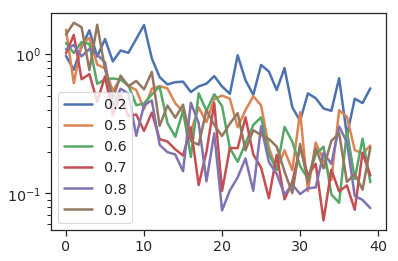

In [195]:
for err, f in zip(errs_all.mean(1), fs):
    plt.plot(err, label=f)
plt.legend()
plt.yscale('log')

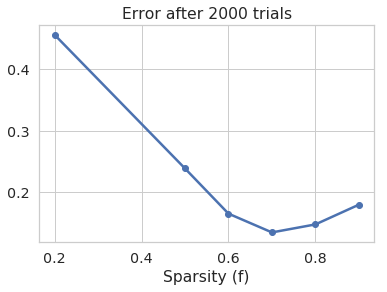

In [209]:
with sns.axes_style('whitegrid'):
    plt.plot(fs,errs_all.mean(1)[:,-10:].mean(-1), 'o-')
    plt.xlabel('Sparsity (f)')
    plt.title('Error after 2000 trials')